Tarea 30 de sept

Experimento 1/10 para Hidden Size 100, Data Size 600
Experimento 2/10 para Hidden Size 100, Data Size 600
Experimento 3/10 para Hidden Size 100, Data Size 600
Experimento 4/10 para Hidden Size 100, Data Size 600
Experimento 5/10 para Hidden Size 100, Data Size 600
Experimento 6/10 para Hidden Size 100, Data Size 600
Experimento 7/10 para Hidden Size 100, Data Size 600
Experimento 8/10 para Hidden Size 100, Data Size 600
Experimento 9/10 para Hidden Size 100, Data Size 600
Experimento 10/10 para Hidden Size 100, Data Size 600
Hidden Size: 100, Data Size: 600, E_in: 0.0618 ± 0.0146, E_out: 0.1431 ± 0.0083
Experimento 1/10 para Hidden Size 100, Data Size 3000
Experimento 2/10 para Hidden Size 100, Data Size 3000
Experimento 3/10 para Hidden Size 100, Data Size 3000
Experimento 4/10 para Hidden Size 100, Data Size 3000
Experimento 5/10 para Hidden Size 100, Data Size 3000
Experimento 6/10 para Hidden Size 100, Data Size 3000
Experimento 7/10 para Hidden Size 100, Data Size 3000
Experimento

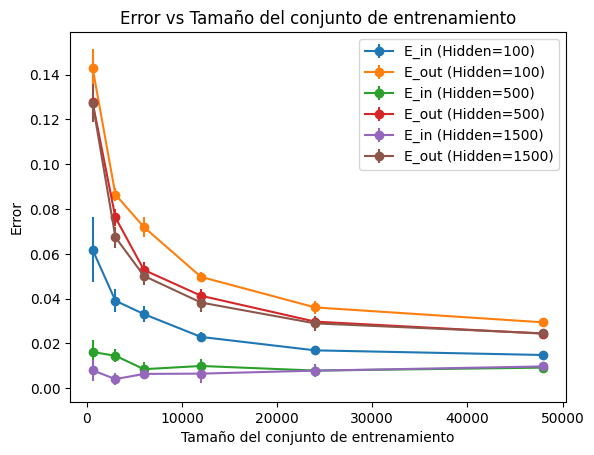

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# Configurar dispositivo (usar GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir la red neuronal con un parámetro para el tamaño de la capa oculta
class NeuralNet(nn.Module):
    def __init__(self, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)  # Capa de entrada y capa oculta
        self.relu = nn.ReLU()  # Función de activación
        self.fc2 = nn.Linear(hidden_size, 10)  # Capa de salida para 10 clases

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplanar la imagen (28x28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hiperparámetros
batch_size = 64
learning_rate = 0.001
num_epochs = 5  # Reducido para acelerar los experimentos
T = 10  # Número de repeticiones por experimento

# Preparar el dataset MNIST completo
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Parámetros del experimento
neuron_sizes = [100, 500, 1500]  # Tamaños de la capa oculta
dataset_percentages = [1, 5, 10, 20, 40, 80]  # Porcentajes del conjunto de entrenamiento

# Almacenar resultados
results = {}

for hidden_size in neuron_sizes:
    results[hidden_size] = {'dataset_sizes': [], 'E_in_mean': [], 'E_in_std': [], 'E_out_mean': [], 'E_out_std': []}
    for percentage in dataset_percentages:
        E_in_list = []
        E_out_list = []
        dataset_size = int(len(full_train_dataset) * (percentage / 100))
        results[hidden_size]['dataset_sizes'].append(dataset_size)
        for t in range(T):
            print(f'Experimento {t + 1}/{T} para Hidden Size {hidden_size}, Data Size {dataset_size}')
            # Muestrear aleatoriamente un subconjunto del conjunto de entrenamiento
            indices = np.random.choice(len(full_train_dataset), dataset_size, replace=False)
            subset_train_dataset = Subset(full_train_dataset, indices)
            train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

            # Crear el modelo, definir la función de pérdida y el optimizador
            model = NeuralNet(hidden_size).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Entrenamiento
            model.train()
            for epoch in range(num_epochs):
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

            # Evaluación en el conjunto de entrenamiento (E_in)
            correct_in = 0
            total_in = 0
            model.eval()
            with torch.no_grad():
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_in += pred.eq(target.view_as(pred)).sum().item()
                    total_in += target.size(0)
            E_in = 1 - (correct_in / total_in)

            # Evaluación en el conjunto de prueba (E_out)
            correct_out = 0
            total_out = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    pred = output.argmax(dim=1, keepdim=True)
                    correct_out += pred.eq(target.view_as(pred)).sum().item()
                    total_out += target.size(0)
            E_out = 1 - (correct_out / total_out)

            # Almacenar errores
            E_in_list.append(E_in)
            E_out_list.append(E_out)

        # Calcular media y desviación estándar
        E_in_mean = np.mean(E_in_list)
        E_in_std = np.std(E_in_list)
        E_out_mean = np.mean(E_out_list)
        E_out_std = np.std(E_out_list)

        results[hidden_size]['E_in_mean'].append(E_in_mean)
        results[hidden_size]['E_in_std'].append(E_in_std)
        results[hidden_size]['E_out_mean'].append(E_out_mean)
        results[hidden_size]['E_out_std'].append(E_out_std)

        print(f'Hidden Size: {hidden_size}, Data Size: {dataset_size}, E_in: {E_in_mean:.4f} ± {E_in_std:.4f}, E_out: {E_out_mean:.4f} ± {E_out_std:.4f}')

# Graficar los resultados
import matplotlib.pyplot as plt

for hidden_size in neuron_sizes:
    data_sizes = results[hidden_size]['dataset_sizes']
    E_in_mean = results[hidden_size]['E_in_mean']
    E_in_std = results[hidden_size]['E_in_std']
    E_out_mean = results[hidden_size]['E_out_mean']
    E_out_std = results[hidden_size]['E_out_std']

    plt.errorbar(data_sizes, E_in_mean, yerr=E_in_std, label=f'E_in (Hidden={hidden_size})', fmt='-o')
    plt.errorbar(data_sizes, E_out_mean, yerr=E_out_std, label=f'E_out (Hidden={hidden_size})', fmt='-o')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error')
plt.title('Error vs Tamaño del conjunto de entrenamiento')
plt.legend()
plt.show()

Modificado para dataset German Credit Risk

Unnamed: 0                     float64
Age                            float64
Job                            float64
Credit amount                  float64
Duration                       float64
Sex_male                       float64
Housing_own                    float64
Housing_rent                   float64
Saving accounts_little         float64
Saving accounts_moderate       float64
Saving accounts_quite rich     float64
Saving accounts_rich           float64
Checking account_little        float64
Checking account_moderate      float64
Checking account_rich          float64
Purpose_car                    float64
Purpose_domestic appliances    float64
Purpose_education              float64
Purpose_furniture/equipment    float64
Purpose_radio/TV               float64
Purpose_repairs                float64
Purpose_vacation/others        float64
dtype: object
Experimento 1/10 para Hidden Size 250, Data Size 80
Experimento 2/10 para Hidden Size 250, Data Size 80
Experimento 3/10 para Hi

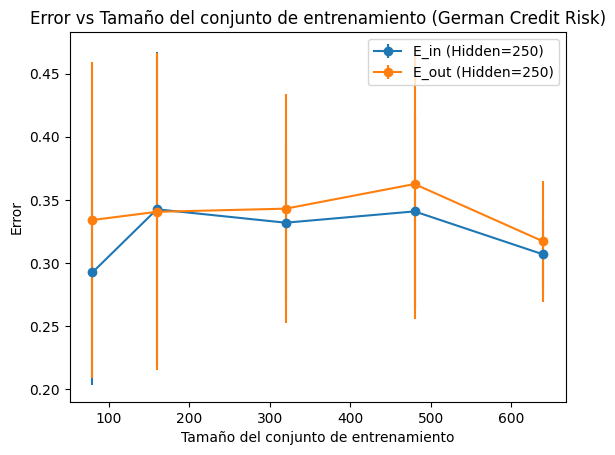

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Configurar dispositivo (usar GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Cargar y preprocesar el dataset German Credit Risk
# Leer el CSV utilizando pandas
data = pd.read_csv('german_credit_risk.csv')

# Definir columnas categóricas y numéricas
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
numeric_cols = ['Age', 'Job', 'Credit amount', 'Duration']

# a. Manejar valores faltantes
# Reemplazar 'NA', 'NaN' y None por 'Unknown' en variables categóricas
data[categorical_cols] = data[categorical_cols].replace(['NA', 'NaN', None], 'Unknown')

# Rellenar valores faltantes en variables numéricas con la media
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# b. Codificar variables categóricas usando One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# **Mover esta línea antes de la conversión a float**
# Codificar la etiqueta 'Risk' a valores numéricos
data['Risk'] = data['Risk'].map({'bad': 0, 'good': 1})

# c. Convertir todos los tipos de datos a float
data = data.astype(float)

# Separar características y etiquetas
X = data.drop('Risk', axis=1)
y = data['Risk']

# Verificar tipos de datos
print(X.dtypes)

# Escalar características numéricas
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Crear un Dataset personalizado para PyTorch
class CreditDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Añadir dimensión para la salida

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear los datasets de entrenamiento y prueba
full_train_dataset = CreditDataset(X_train_full, y_train_full)
test_dataset = CreditDataset(X_test, y_test)

# 3. Definir la red neuronal con un parámetro para el tamaño de la capa oculta
input_size = X_train_full.shape[1]  # Número de características después del preprocesamiento

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Capa de entrada y capa oculta
        self.relu = nn.ReLU()  # Función de activación
        self.fc2 = nn.Linear(hidden_size, 1)  # Capa de salida para clasificación binaria

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # No aplicar sigmoid aquí si usas BCEWithLogitsLoss
        return x

# Hiperparámetros
batch_size = 64
learning_rate = 0.001
num_epochs = 10  # Puedes ajustarlo según tus necesidades
T = 10  # Número de repeticiones por experimento

# Parámetros del experimento
neuron_sizes = [250]  # Tamaños de la capa oculta ajustados para el nuevo dataset
dataset_percentages = [10, 20, 40, 60, 80]  # Porcentajes del conjunto de entrenamiento

# Almacenar resultados
results = {}

for hidden_size in neuron_sizes:
    results[hidden_size] = {'dataset_sizes': [], 'E_in_mean': [], 'E_in_std': [], 'E_out_mean': [], 'E_out_std': []}
    for percentage in dataset_percentages:
        E_in_list = []
        E_out_list = []
        dataset_size = int(len(full_train_dataset) * (percentage / 100))
        results[hidden_size]['dataset_sizes'].append(dataset_size)
        for t in range(T):
            print(f'Experimento {t + 1}/{T} para Hidden Size {hidden_size}, Data Size {dataset_size}')

            # Muestrear aleatoriamente un subconjunto del conjunto de entrenamiento
            indices = np.random.choice(len(full_train_dataset), dataset_size, replace=False)
            subset_train_dataset = Subset(full_train_dataset, indices)
            train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

            # Crear el modelo, definir la función de pérdida y el optimizador
            model = NeuralNet(input_size, hidden_size).to(device)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Entrenamiento
            model.train()
            for epoch in range(num_epochs):
                for data_batch, target_batch in train_loader:
                    data_batch, target_batch = data_batch.to(device), target_batch.to(device)
                    optimizer.zero_grad()
                    output = model(data_batch)
                    loss = criterion(output, target_batch)
                    loss.backward()
                    optimizer.step()

            # Evaluación en el conjunto de entrenamiento (E_in)
            correct_in = 0
            total_in = 0
            model.eval()
            with torch.no_grad():
                for data_batch, target_batch in train_loader:
                    data_batch, target_batch = data_batch.to(device), target_batch.to(device)
                    output = model(data_batch)
                    pred = torch.sigmoid(output)
                    predicted = (pred > 0.5).float()
                    correct_in += (predicted.eq(target_batch)).sum().item()
                    total_in += target_batch.size(0)
            E_in = 1 - (correct_in / total_in)

            # Evaluación en el conjunto de prueba (E_out)
            correct_out = 0
            total_out = 0
            with torch.no_grad():
                for data_batch, target_batch in test_loader:
                    data_batch, target_batch = data_batch.to(device), target_batch.to(device)
                    output = model(data_batch)
                    pred = torch.sigmoid(output)
                    predicted = (pred > 0.5).float()
                    correct_out += (predicted.eq(target_batch)).sum().item()
                    total_out += target_batch.size(0)
            E_out = 1 - (correct_out / total_out)

            # Almacenar errores
            E_in_list.append(E_in)
            E_out_list.append(E_out)

        # Calcular media y desviación estándar
        E_in_mean = np.mean(E_in_list)
        E_in_std = np.std(E_in_list)
        E_out_mean = np.mean(E_out_list)
        E_out_std = np.std(E_out_list)

        results[hidden_size]['E_in_mean'].append(E_in_mean)
        results[hidden_size]['E_in_std'].append(E_in_std)
        results[hidden_size]['E_out_mean'].append(E_out_mean)
        results[hidden_size]['E_out_std'].append(E_out_std)

        print(f'Hidden Size: {hidden_size}, Data Size: {dataset_size}, E_in: {E_in_mean:.4f} ± {E_in_std:.4f}, E_out: {E_out_mean:.4f} ± {E_out_std:.4f}')

# Graficar los resultados
for hidden_size in neuron_sizes:
    data_sizes = results[hidden_size]['dataset_sizes']
    E_in_mean = results[hidden_size]['E_in_mean']
    E_in_std = results[hidden_size]['E_in_std']
    E_out_mean = results[hidden_size]['E_out_mean']
    E_out_std = results[hidden_size]['E_out_std']

    plt.errorbar(data_sizes, E_in_mean, yerr=E_in_std, label=f'E_in (Hidden={hidden_size})', fmt='-o')
    plt.errorbar(data_sizes, E_out_mean, yerr=E_out_std, label=f'E_out (Hidden={hidden_size})', fmt='-o')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error')
plt.title('Error vs Tamaño del conjunto de entrenamiento (German Credit Risk)')
plt.legend()
plt.show()


Credit Risk v2

Experimento 1/10 para Hidden Size 5, Data Size 160
Experimento 2/10 para Hidden Size 5, Data Size 160
Experimento 3/10 para Hidden Size 5, Data Size 160
Experimento 4/10 para Hidden Size 5, Data Size 160
Experimento 5/10 para Hidden Size 5, Data Size 160
Experimento 6/10 para Hidden Size 5, Data Size 160
Experimento 7/10 para Hidden Size 5, Data Size 160
Experimento 8/10 para Hidden Size 5, Data Size 160
Experimento 9/10 para Hidden Size 5, Data Size 160
Experimento 10/10 para Hidden Size 5, Data Size 160
Hidden Size: 5, Data Size: 160, E_in: 0.4144 ± 0.1789, E_out: 0.4205 ± 0.1863
Experimento 1/10 para Hidden Size 5, Data Size 320
Experimento 2/10 para Hidden Size 5, Data Size 320
Experimento 3/10 para Hidden Size 5, Data Size 320
Experimento 4/10 para Hidden Size 5, Data Size 320
Experimento 5/10 para Hidden Size 5, Data Size 320
Experimento 6/10 para Hidden Size 5, Data Size 320
Experimento 7/10 para Hidden Size 5, Data Size 320
Experimento 8/10 para Hidden Size 5, Data Size 320
Exp

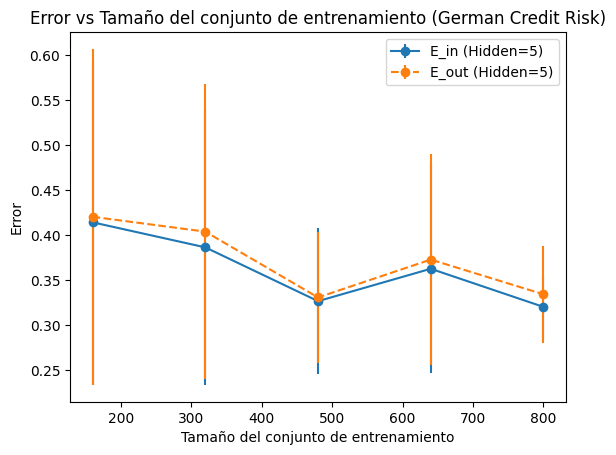

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Configurar dispositivo (usar GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Cargar y preprocesar el dataset German Credit Risk
# Leer el CSV utilizando pandas
data = pd.read_csv('german_credit_risk.csv')

# Definir columnas categóricas y numéricas
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
numeric_cols = ['Age', 'Job', 'Credit amount', 'Duration']

# a. Manejar valores faltantes
# Reemplazar 'NA', 'NaN' y None por 'Unknown' en variables categóricas
data[categorical_cols] = data[categorical_cols].replace(['NA', 'NaN', None], 'Unknown')

# Rellenar valores faltantes en variables numéricas con la media
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# b. Codificar variables categóricas usando One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Codificar la etiqueta 'Risk' a valores numéricos
data['Risk'] = data['Risk'].map({'bad': 0, 'good': 1})

# c. Convertir todos los tipos de datos a float
data = data.astype(float)

# Separar características y etiquetas
X = data.drop('Risk', axis=1)
y = data['Risk']

# Dividir los datos en conjuntos de entrenamiento y prueba de forma estratificada
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Reiniciar los índices para evitar problemas con índices desalineados
X_train_full.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Escalar características numéricas en X_train_full
scaler = StandardScaler()
X_train_full.loc[:, numeric_cols] = scaler.fit_transform(X_train_full[numeric_cols])

# Escalar características numéricas en X_test utilizando el scaler ajustado
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

# 2. Crear un Dataset personalizado para PyTorch
class CreditDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Añadir dimensión para la salida

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear el dataset de prueba
test_dataset = CreditDataset(X_test, y_test)

# 3. Definir la red neuronal con un parámetro para el tamaño de la capa oculta
input_size = X_train_full.shape[1]  # Número de características después del preprocesamiento

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Capa de entrada y capa oculta
        self.relu = nn.ReLU()  # Función de activación
        self.dropout = nn.Dropout(dropout_rate)  # Dropout para regularización
        self.fc2 = nn.Linear(hidden_size, 1)  # Capa de salida para clasificación binaria

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Aplicar dropout
        x = self.fc2(x)
        return x

# Hiperparámetros
batch_size = 32  # Reducir el tamaño del batch para datasets pequeños
learning_rate = 0.001
num_epochs = 10 # Aumentar el número de épocas
T = 10  # Número de repeticiones por experimento

# Parámetros del experimento
neuron_sizes = [5]  # Tamaños de la capa oculta reducidos
dataset_percentages = [20, 40, 60, 80, 100]  # Evitar tamaños muy pequeños

# Calcular los pesos de clase para compensar el desbalance
class_counts = y_train_full.value_counts()
class_weights = {
    0: len(y_train_full) / class_counts[0],
    1: len(y_train_full) / class_counts[1]
}
weights = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

# Almacenar resultados
results = {}

for hidden_size in neuron_sizes:
    results[hidden_size] = {'dataset_sizes': [], 'E_in_mean': [], 'E_in_std': [], 'E_out_mean': [], 'E_out_std': []}
    for percentage in dataset_percentages:
        E_in_list = []
        E_out_list = []
        dataset_size = int(len(y_train_full) * (percentage / 100))
        results[hidden_size]['dataset_sizes'].append(dataset_size)
        for t in range(T):
            print(f'Experimento {t + 1}/{T} para Hidden Size {hidden_size}, Data Size {dataset_size}')

            # Caso especial cuando el porcentaje es 100%
            if percentage == 100:
                X_train_subset = X_train_full.copy()
                y_train_subset = y_train_full.copy()
            else:
                # Muestrear aleatoriamente un subconjunto estratificado del conjunto de entrenamiento
                sss = StratifiedShuffleSplit(n_splits=1, train_size=dataset_size, random_state=t)
                for train_index, _ in sss.split(X_train_full, y_train_full):
                    X_train_subset = X_train_full.iloc[train_index].copy()
                    y_train_subset = y_train_full.iloc[train_index].reset_index(drop=True)

            # Escalar características numéricas del subconjunto utilizando el scaler ajustado
            X_train_subset.loc[:, numeric_cols] = scaler.transform(X_train_subset[numeric_cols])

            # Crear el dataset y el DataLoader
            train_dataset = CreditDataset(X_train_subset, y_train_subset)
            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

            # Crear el modelo, definir la función de pérdida y el optimizador
            model = NeuralNet(input_size, hidden_size).to(device)
            criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])  # Ajustar el peso de la clase positiva
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Agregar weight decay

            # Entrenamiento
            model.train()
            for epoch in range(num_epochs):
                running_loss = 0.0
                correct = 0
                total = 0
                for data_batch, target_batch in train_loader:
                    data_batch, target_batch = data_batch.to(device), target_batch.to(device)
                    optimizer.zero_grad()
                    output = model(data_batch)
                    loss = criterion(output, target_batch)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    pred = torch.sigmoid(output)
                    predicted = (pred > 0.5).float()
                    correct += (predicted.eq(target_batch)).sum().item()
                    total += target_batch.size(0)

                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct / total
                # Puedes descomentar la siguiente línea para ver el progreso en cada época
                # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Evaluación en el conjunto de entrenamiento (E_in)
            correct_in = 0
            total_in = 0
            model.eval()
            with torch.no_grad():
                for data_batch, target_batch in train_loader:
                    data_batch, target_batch = data_batch.to(device), target_batch.to(device)
                    output = model(data_batch)
                    pred = torch.sigmoid(output)
                    predicted = (pred > 0.5).float()
                    correct_in += (predicted.eq(target_batch)).sum().item()
                    total_in += target_batch.size(0)
            E_in = 1 - (correct_in / total_in)

            # Evaluación en el conjunto de prueba (E_out)
            correct_out = 0
            total_out = 0
            with torch.no_grad():
                for data_batch, target_batch in test_loader:
                    data_batch, target_batch = data_batch.to(device), target_batch.to(device)
                    output = model(data_batch)
                    pred = torch.sigmoid(output)
                    predicted = (pred > 0.5).float()
                    correct_out += (predicted.eq(target_batch)).sum().item()
                    total_out += target_batch.size(0)
            E_out = 1 - (correct_out / total_out)

            # Almacenar errores
            E_in_list.append(E_in)
            E_out_list.append(E_out)

        # Calcular media y desviación estándar
        E_in_mean = np.mean(E_in_list)
        E_in_std = np.std(E_in_list)
        E_out_mean = np.mean(E_out_list)
        E_out_std = np.std(E_out_list)

        results[hidden_size]['E_in_mean'].append(E_in_mean)
        results[hidden_size]['E_in_std'].append(E_in_std)
        results[hidden_size]['E_out_mean'].append(E_out_mean)
        results[hidden_size]['E_out_std'].append(E_out_std)

        print(f'Hidden Size: {hidden_size}, Data Size: {dataset_size}, E_in: {E_in_mean:.4f} ± {E_in_std:.4f}, E_out: {E_out_mean:.4f} ± {E_out_std:.4f}')

# Graficar los resultados
for hidden_size in neuron_sizes:
    data_sizes = results[hidden_size]['dataset_sizes']
    E_in_mean = results[hidden_size]['E_in_mean']
    E_in_std = results[hidden_size]['E_in_std']
    E_out_mean = results[hidden_size]['E_out_mean']
    E_out_std = results[hidden_size]['E_out_std']

    plt.errorbar(data_sizes, E_in_mean, yerr=E_in_std, label=f'E_in (Hidden={hidden_size})', fmt='-o')
    plt.errorbar(data_sizes, E_out_mean, yerr=E_out_std, label=f'E_out (Hidden={hidden_size})', fmt='--o')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error')
plt.title('Error vs Tamaño del conjunto de entrenamiento (German Credit Risk)')
plt.legend()
plt.show()